In [1]:
import numpy as np
import matplotlib.pyplot as plt
import poppy
import astropy.units as u
from custom_optics import ShiftedGaussianAperture

# Set up poppy optical system with decentered aperture and defocus

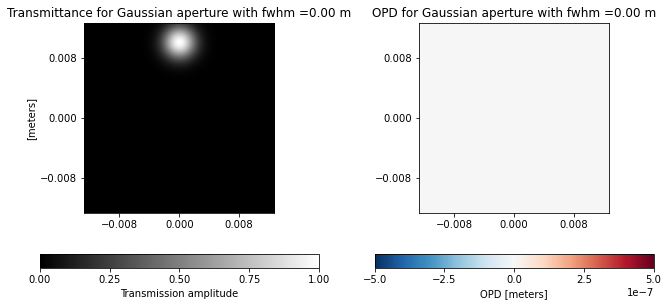

Oversampling > 2x suggested for reliable results in Fresnel propagation.


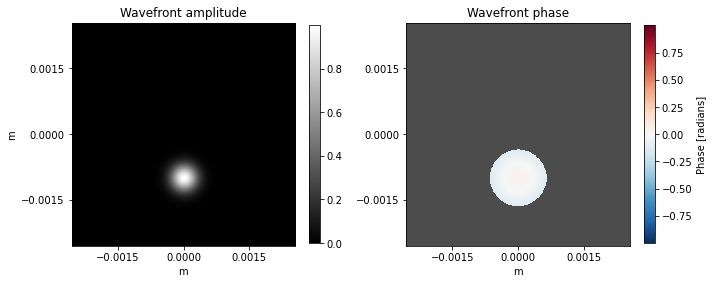

In [99]:
pupil_d = 25.4e-3*u.m
wvl = 1e-6*u.m
npix = 512
OS = 1
efl = 100e-3*u.m

aper = ShiftedGaussianAperture(w=3e-3*u.m,shifty=1e-2*u.m,pupil_diam=pupil_d)
thin_lens = poppy.QuadraticLens(efl)

plt.figure(figsize=[11,5])
aper.display(what='both')
plt.show()

wf = poppy.FresnelWavefront(pupil_d,wavelength=wvl,npix=npix,oversample=OS)
wf *= aper
wf *= thin_lens
wf.propagate_fresnel(efl + 10e-3*u.m)

plt.figure(figsize=[11,5])
wf.display(what='both',colorbar=True)
plt.show()


In [100]:
# Use wf as our template for detector of beamlet simulation
pixscale = wf.pixelscale.value # m'/pix
size = wf.amplitude.shape[0]

x = np.linspace(-size*pixscale/2,size*pixscale/2,size)
x,y = np.meshgrid(x,x)
r2 = np.array([x,y])
r2 = np.moveaxis(r2,-1,0)
r2 = np.moveaxis(r2,-1,0)
r2 = r2[...,np.newaxis]
print(r2.shape)

(512, 512, 2, 1)


# Configure a Ray Transfer Matrix and Gaussian Beam Propgation using the proposed method

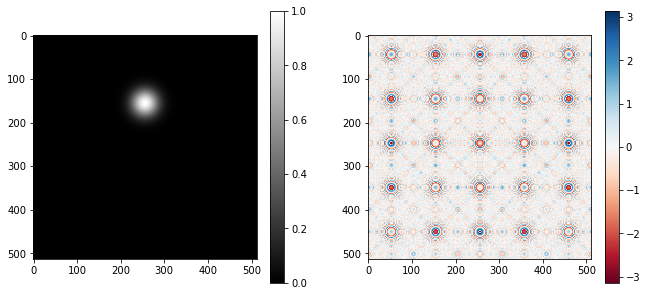

In [101]:
def propagate_qpinv_abcd(Qinv,A,B,C,D):

    num = C + D @ Qinv
    den = A + B @ Qinv

    return num @ np.linalg.inv(den)

def propagate_aligned_gaussian(Qpinv,x2,y2,k):

    phase = -1j*k/2*((x2*Qpinv[0,0] + y2*Qpinv[1,0])*x2 + (x2*Qpinv[0,1] + y2*Qpinv[1,1])*y2)

    return np.exp(phase)

def compute_misalign_phase(B,A,r1m,r2,k):
    """
    Parameters
    ----------
    B,A : numpy.ndarrays
        elements of the ray transfer matrix 
    r1m : numpy.ndarray of size 2
        misalignment in position in x then y
    r2 : numpy.ndarray of dimension 2
        detector coordinates in x and y. First dimension holds x/y, second holds coordinate
    k : float, complex
        wave number of simulation
    """
    Binv = np.linalg.inv(B)
    BinvA = Binv @ A
    t1 = r1m.T @ BinvA @ r1m
    t1 = t1[...,0,0]
    t2 = -2 * r1m.T @ Binv @ r2
    t2 = t2[...,0,0]

    return np.exp(-1j*k/2*(t1 + t2))

def compute_gaussian_amplitude(Qpinv,A,B):

    den = A + np.linalg.inv(B) @ Qpinv

    return 1/np.sqrt(np.linalg.det(den))

def propagate_misaligned_gaussian(Qpinv,r1m,r2,k,A,B,rayprop):

    x2,y2 = r2[...,0,0]-rayprop[0,0],r2[...,1,0]-rayprop[1,0]
    misalign = compute_misalign_phase(B,A,r1m,r2,k)
    aligned = propagate_aligned_gaussian(Qpinv,x2,y2,k)
    amplitude = compute_gaussian_amplitude(Qpinv,A,B)

    return amplitude*misalign*aligned


# system parameters
efl = 100e-3 # meters
prop = efl + 10e-3
wo = 3e-3
qinv = -1j*wvl.value / (np.pi * wo**2)
Qinv = np.array([[qinv,0],
                 [0,qinv]])

# misalign vector
r1m = np.array([0,1e-2])[...,np.newaxis]
ray = np.array([0,1e-2,0,0])[...,np.newaxis]

# set up detector

# make ray transfer matrices
focus = np.array([[1,0,0,0],
                  [0,1,0,0],
                  [-1/efl,0,1,0],
                  [0,-1/efl,0,1]])

propagate = np.array([[1,0,prop,0],
                      [0,1,0,prop],
                      [0,0,1,0],
                      [0,0,0,1]])

ABCD = propagate @ focus
A = ABCD[:2,:2]
B = ABCD[:2,2:4]
C = ABCD[2:4,:2]
D = ABCD[2:4,2:4]
rayprop = ABCD @ ray

# propagate the Q matrix
Qpinv = propagate_qpinv_abcd(Qinv,A,B,C,D)
field = propagate_misaligned_gaussian(Qpinv,r1m,r2,2*np.pi/wvl.value,A,B,rayprop)
field /= np.max(np.abs(field))
dummy = np.linspace(-1,1,2048)

plt.figure(figsize=[11,5])
plt.subplot(121)
plt.imshow(np.abs(field),cmap='gray')
plt.colorbar()
plt.subplot(122)
plt.imshow(np.angle(field),cmap='RdBu')
plt.colorbar()
plt.show()


<ipython-input-102-ae4747493ebb>:14: RuntimeWarning: divide by zero encountered in divide
  frac_dif_field = (np.abs(field_poppy)**2-np.abs(field)**2)/np.abs(field_poppy)**2 * 100


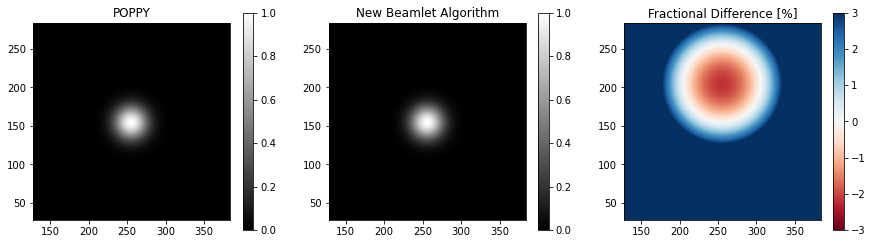

In [102]:
from scipy.ndimage import shift
from matplotlib.colors import LogNorm
field_poppy = shift(wf.wavefront,[-0.5,-0.5])
field_poppy /= np.max(np.abs(field_poppy))
mid = int(field_poppy.shape[0]/2)
cut = 128
yshift = -100

frac_dif = 3
threshold = 1/(np.exp(1)**3)
mask = np.abs(np.copy(field_poppy))
mask[field_poppy > threshold] = 1
mask[field_poppy <= threshold] = 0
frac_dif_field = (np.abs(field_poppy)**2-np.abs(field)**2)/np.abs(field_poppy)**2 * 100

plt.figure(figsize=[15,4])
plt.subplot(131)
plt.title('POPPY')
plt.imshow(np.abs(field_poppy)**2,cmap='gray')
plt.colorbar()
plt.xlim([mid-cut,mid+cut])
plt.ylim([mid-cut+yshift,mid+cut+yshift])
plt.subplot(132)
plt.title('New Beamlet Algorithm')
plt.imshow(np.abs(field)**2,cmap='gray')
plt.colorbar()
plt.xlim([mid-cut,mid+cut])
plt.ylim([mid-cut+yshift,mid+cut+yshift])
plt.subplot(133)
plt.title('Fractional Difference [%]')
plt.imshow(frac_dif_field,cmap='RdBu',vmin=-frac_dif,vmax=frac_dif)
plt.xlim([mid-cut,mid+cut])
plt.ylim([mid-cut+yshift,mid+cut+yshift])
plt.colorbar()
plt.show()

In [13]:
from scipy.ndimage import center_of_mass
# print(center_of_mass(np.abs(field)**2))
# print(center_of_mass(np.abs(field_poppy)**2))

print(np.std(np.abs(field)**2 - np.abs(field_poppy)**2))

(154.90947355002203, 255.49999999999991)
(154.71262320456503, 255.50000000000003)
0.0005096343874363536


In [81]:
def compute_std_vs_oversample():

    stdlist = []
    os = np.arange(1,33,1)

    for OS in os:

        OS = int(OS)
    
        "The POPPY Simulation"
        pupil_d = 25.4e-3*u.m
        wvl = 1e-6*u.m
        npix = 128
        efl = 100e-3
        prop = 100e-3 + 1e-3

        aper = ShiftedGaussianAperture(w=1e-3*u.m,shifty=1e-2*u.m,pupil_diam=pupil_d)
        thin_lens = poppy.QuadraticLens(efl*u.m)

        wf = poppy.FresnelWavefront(pupil_d,wavelength=wvl,npix=npix,oversample=OS)
        wf *= aper
        wf *= thin_lens
        wf.propagate_fresnel(prop*u.m)

        field_poppy = shift(wf.wavefront,[-0.5,-0.5])
        field_poppy /= np.max(np.abs(field_poppy))

        "the beamlet simulation"
        # Use wf as our template for detector of beamlet simulation
        pixscale = wf.pixelscale.value # m'/pix
        size = wf.amplitude.shape[0]

        x = np.linspace(-size*pixscale/2,size*pixscale/2,size)
        x,y = np.meshgrid(x,x)
        r2 = np.array([x,y])
        r2 = np.moveaxis(r2,-1,0)
        r2 = np.moveaxis(r2,-1,0)
        r2 = r2[...,np.newaxis]

        wo = 1e-3
        qinv = -1j*wvl.value / (np.pi * wo**2)
        Qinv = np.array([[qinv,0],
                        [0,qinv]])

        # misalign vector
        r1m = np.array([0,1e-2])[...,np.newaxis]
        ray = np.array([0,1e-2,0,0])[...,np.newaxis]

        # set up detector
        # make ray transfer matrices
        focus = np.array([[1,0,0,0],
                        [0,1,0,0],
                        [-1/efl,0,1,0],
                        [0,-1/efl,0,1]])

        propagate = np.array([[1,0,prop,0],
                            [0,1,0,prop],
                            [0,0,1,0],
                            [0,0,0,1]])

        ABCD = propagate @ focus
        A = ABCD[:2,:2]
        B = ABCD[:2,2:4]
        C = ABCD[2:4,:2]
        D = ABCD[2:4,2:4]
        rayprop = ABCD @ ray

        # propagate the Q matrix
        Qpinv = propagate_qpinv_abcd(Qinv,A,B,C,D)
        field = propagate_misaligned_gaussian(Qpinv,r1m,r2,2*np.pi/wvl.value,A,B,rayprop)
        field /= np.max(np.abs(field))

        # Compute the difference
        diff_irradiance = np.abs(field)**2 - np.abs(field_poppy)**2
        stdlist.append(np.std(diff_irradiance))

    return os,stdlist

In [82]:
os,stddev = compute_std_vs_oversample()

Oversampling > 2x suggested for reliable results in Fresnel propagation.


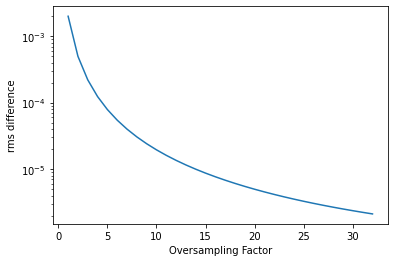

In [83]:
plt.figure()
plt.plot(os,stddev)
plt.xlabel('Oversampling Factor')
plt.ylabel('rms difference')
plt.yscale('log')
plt.show()

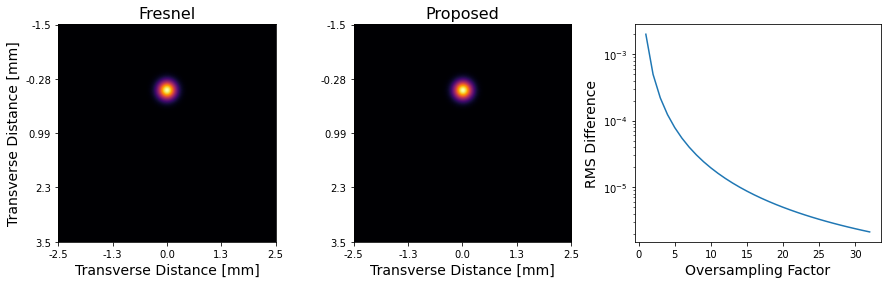

In [103]:
# config proper ticks
nticks = 5
fsize=14
ticklocs = np.linspace(0,field.shape[0],nticks)
ticks = np.linspace(-pixscale*field.shape[0]/2,pixscale*field.shape[0]/2,nticks)*1e3
tickstr = [f'{i:.2}' for i in ticks]
ytickstr = [f'{i+100*1e3*pixscale:.2}' for i in ticks]
stddev_scaled = [i*1e3 for i in stddev]


fig,axs = plt.subplots(ncols=3,figsize=[15,4])
for ax,data,title in zip(axs[:2],[field_poppy,field],['Fresnel','Proposed']):

    ax.imshow(np.abs(data)**2,cmap='inferno')
    ax.set_xticks(ticklocs)
    ax.set_xticklabels(tickstr)
    ax.set_yticks(ticklocs)
    ax.set_yticklabels(ytickstr)
    ax.set_ylabel('Transverse Distance [mm]',fontsize=fsize)
    ax.set_xlabel('Transverse Distance [mm]',fontsize=fsize)
    ax.set_title(title,fontsize=16)

ax.set_ylabel('')

# configure the next plot
axs[2].plot(os,stddev)
axs[2].set_xlabel('Oversampling Factor',fontsize=fsize)
axs[2].set_ylabel('RMS Difference',fontsize=fsize)
axs[2].set_yscale('log')

plt.show()